# Konwolucyjne sieci neuronowe do transformacji stylu artystycznego

* [Wstęp](#Wstęp)
* [Teoria](#Teoria)
* [Implementacja](#Implementacja)
* [Podsumowanie](#Podsumowanie)

# Wstęp

Gatys w swoim [artykule](https://arxiv.org/abs/1508.06576) pokazują, że jeśli weźmiemy splotową sieć neuronową, która została już przeszkolona do rozpoznawania obiektów w obrazach, wówczas ta sieć rozwinie niektóre wewnętrzne reprezentacje treści i stylu zawartego w danym obrazie. Co więcej, reprezentacje te będą od siebie niezależne, więc możemy użyć reprezentacji treści z jednego obrazu i reprezentacji stylu z innego, aby wygenerować zupełnie nowy obraz.

Jednym z najbardziej popularnych testów porównawczych dla algorytmów klasyfikacji obrazów jest dziś Wyzwanie w [ImageNet](www.image-net.org) - gdzie zespoły rywalizują o tworzenie algorytmów które rozpoznają obiekty z 1000 różnych kategorii.

W 2014 r. zwycięzcą wyzwania ImageNet była sieć stworzona przez grupę Visual Geometry Group (VGG) na Uniwersytecie w Oxfordzie, uzyskując wskaźnik błędu klasyfikacji wynoszący jedynie 7,0%. Gatys użył jej jako podstawy do prób wydobywania treści i stylów z obrazów.

# Teoria

### Wstępna obróbka obrazów 

Dla lepszych efektów warto dopasować dane, tak jak w [Simonyan i Zisserman (2015)](https://arxiv.org/abs/1409.1556).

W tym celu musimy wykonać dwie transformacje:

* Odjąć średnią wartość RGB uzyskaną z zestawu szkoleniowego, wartości te można znaleźć w google.
* Obrócić tablice z RGB na BGR

### Reprezentacja Treści

Sieć, która została przeszkolona w zakresie rozpoznawania obiektów, dowiedziała się które cechy należy wyodrębnić z obrazu, aby zidentyfikować jego zawartość. Mapy cech w warstwach splotów mogą być postrzegane jako wewnętrzna reprezentacja treści obrazu w sieci.

### Reprezentacja Stylu 

W przeciwieństwie do reprezentacji treści, styl obrazu nie jest dobrze uchwycony przez proste spojrzenie na wartości mapy cech w splotowej sieci neuronowej wytrenowanej do rozpoznawania obiektów.

[Gatys](https://arxiv.org/abs/1508.06576) stwierdził, że możemy wyodrębnić reprezentację stylu, patrząc na przestrzenną korelację wartości w obrębie danej mapy cech. Matematycznie odbywa się to poprzez obliczenie macierzy Gram mapy cech. Jeżeli mapa cech jest macierzą F, wtedy dla każdego wpisu w macierz Gramy G można przedstawić jako:

\begin{equation*}
G_{ij} = \sum_k{F_{ij}F_{jk}}
\end{equation*}

Jeżeli dwa obrazy których macierz Gramy jest taka sama możemy stwierdzić, że oba te obrazy posiadają ten sam styl ale nie koniecznie tę samą treść. Gatys stwierdził, że najlepsze wyniki uzyskano, stosując kombinację płytkich i głębokich warstw jako reprezentację stylu dla obrazu.

### Transfer stylu jako problem optymalizacyjny

Transfer stylu jest zadaniem generowania nowego obrazu $Y$, którego styl jest równy obrazowi stylu $S$ i którego treść jest równa treści obrazu $C$. Teraz, gdy mamy jasną definicję stylu i reprezentacji treści obrazu, możemy zdefiniować funkcję utraty, która zasadniczo pokazuje nam, jak daleko od nas jest generowany obraz $Y$ jest doskonałym transferem stylu.

Transfer stylu polega na generowaniu nowego obrazu $Y$, którego styl jest taki sam jak styl obrazu $S$ i którego treść jest równa treści obrazu $C$. Funkcja kosztu zasadniczo pokazuje nam jak dobrze został odwzorowany styl obrazu $S$.

Biorąc warstwę treści $L$, utrata treści jest definiowana jako odległość euklidesowa między mapą cech $F^l$ obrazu treści $C$ a mapą cech $P^l$ generowanego obrazu $Y$. Jeżeli treści obrazów $C$ i $Y$ są takie same to koszt jest równy zeru.

\begin{equation*}
L_{content} = \frac{1}{2}\sum_{i,j}{(F^l_{ij} - P^l_{ij})}^2 
\end{equation*}

Podobnie, biorąc pod uwagę wybraną warstwę stylu $l$ utrata stylu jest definiowana jako odległość euklidesowa między macierzą Gram $G^l$ mapy cech naszego stylu obrazu $S$ i macierz Gram $A^l$ mapy cech naszego generowanego obrazu $Y$.

\begin{equation*}
L_{style} = \frac{1}{2}\sum^L_{l=0}{(G^l_{ij} - A^l_{ij})}^2 
\end{equation*}

Napotkałem się na dodatkowej funkcji kosztu nazywaną [*Całkowita utrata wariacji*](https://arxiv.org/abs/1412.0035) która zmniejsza rozmycie obrazu co pozwala na zachowanie jakości generowanego obrazu.

\begin{equation*}
L_{variation} = \sum_{i,j}{((x_{i,j+1}-x_{ij})^2+(x_{i+1,j}-x_{ij})^2)}^{\frac{\beta}{2}}
\end{equation*}

Całkowity koszt to suma $L_{content}$, $L_{style}$ i $L_{variation}$ z współczynnikami α, β i γ.

\begin{equation*}
L_{total} = αL_{content} + βL_{style} + γL_{variation}
\end{equation*}

### Generowany obraz

Aby wygenerować nasz obraz, najpierw rozpoczynamy od losowo utworzonego obrazu. Następnie iteracyjnie poprawiamy obraz za pomocą propagacji wstecznej.

### Na koniec 

Należy odwrócić przekształcenia które wykonaliśmy na początku czyli:
* Dodać średnią wartość RGB uzyskaną z zestawu szkoleniowego.
* Obrócić tablice z BGR na RGB.

# Implementacja

In [2]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Pierwsze czym się zajmiemy to wczytanie zdjęcia które chcemy przerobić oraz zdjęcia którego styl nas interesuje.
Musimy pamiętać aby miały takie same wymiary, dlatego oba zdjęcia należy przeskalować do wspólnego rozmiaru.


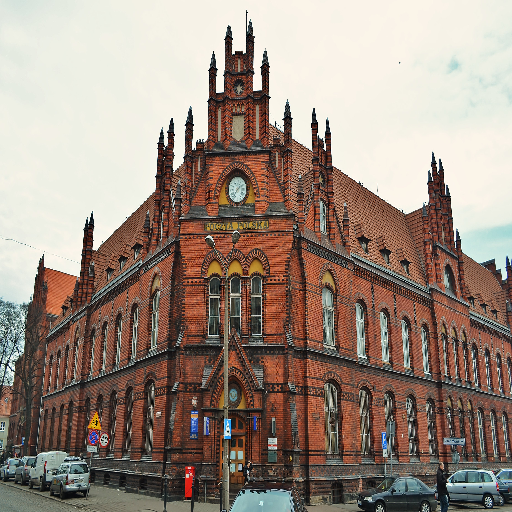

In [21]:
width = height = 512

content_image_src = 'gr.JPG'
content_image = Image.open(content_image_src).resize((width, height))
content_image

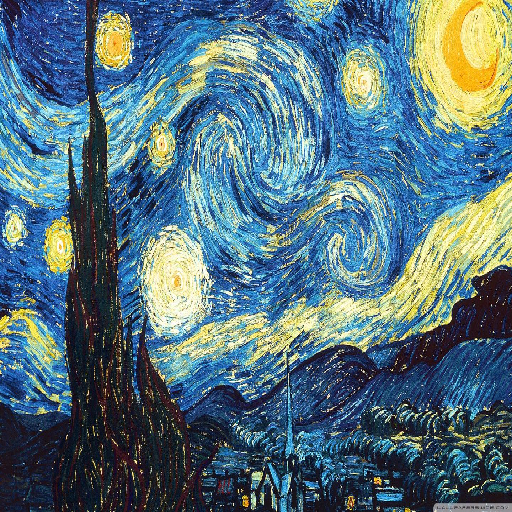

In [22]:
style_image_src = 'st.jpg'
style_image = Image.open(style_image_src).resize((width, height))
style_image

Następnie przekształcamy te obrazy w formę odpowiednią do przetwarzania numerycznego. W szczególności dodajemy inny wymiar (poza klasyczną wysokością x szerokość x 3 wymiary), abyśmy później mogli połączyć reprezentacje tych dwóch obrazów we wspólną strukturę danych.

In [23]:
content_array = np.asarray(content_image, dtype='float32')
style_array = np.asarray(style_image, dtype='float32')

print ('Przed:')
print(content_array.shape)
print(style_array.shape)

print ('Po:')
content_array = np.expand_dims(content_array, axis=0)
style_array = np.expand_dims(style_array, axis=0)
print(content_array.shape) 
print(style_array.shape)

Przed:
(512, 512, 3)
(512, 512, 3)
Po:
(1, 512, 512, 3)
(1, 512, 512, 3)


Zanim przejdziemy dalej, musimy dopasować dane, tak jak w [Simonyan i Zisserman (2015)](https://arxiv.org/abs/1409.1556).

W tym celu musimy wykonać dwie transformacje:

* Odjąć średnią wartość RGB uzyskaną z zestawu szkoleniowego, wartości te można znaleźć w google.
* Obrócić tablice z RGB na BGR

In [24]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Teraz musimy zdefiniować zmienne dla tablic w Keras, dodamy jeszcze jedną tablice która będzie przechowywać kombinacje zdjęcia kontentu i stylu.

In [25]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Na koniec łączymy wszystkie te dane obrazu w jeden tensor, który nadaje się do przetwarzania przez model VGG16 zaimplementowany z biblioteki Keras.

In [26]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

Główną ideą wprowadzoną przez [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) jest fakt, że splotowe sieci neuronowe które są w modelu VGG zostały przeszkolone w zakresie klasyfikacji obrazów i już wiedzą jak kodować percepcyjne i semantyczne informacje o obrazie.



Wykorzystam 16-warstwowy model sieci VGG [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) zamiast 19-warstwowy, 
różnica jest niewielka w obrazie a pozwoli to skrócić czas przetwarzania obrazu.

Ponadto, nie interesuje nas problem klasyfikacji wiec nie potrzebujemy w pełni połączonych warstw oraz klasyfikatora softmax.

In [27]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

Możemy łatwo podejrzeć jakie warstwy znajdują się w naszym modelu.

In [28]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 64, 64, 51

Z [publikacji](https://arxiv.org/abs/1508.06576) wynika, że możemy problem transferu stylu przedstawić jako problem optymalizacyjny  który rozbija się na trzy odrębne części:

* utrata zawartości
* utrata stylu
* całkowitą utratę wariacji

---
Potrzebne będą nam jeszcze odpowiednio dobrane współczynniki wag.
Dobór ich wymaga wielu prób, ja postanowiłem pozostać przy wartościach które znalazłem w [artykule](https://harishnarayanan.org/writing/artistic-style-transfer/).

In [29]:
content_weight = 0.035        # alfa
style_weight = 5              # beta 
total_variation_weight = 0.1  # gama

Teraz wykorzystamy przestrzenie cech dostarczone przez określone warstwy naszego modelu, aby zdefiniować te trzy funkcje straty.

Zainicjujmy ją wartością zero, będziemy do niej dodawać pozostałe koszta.

In [30]:
loss = backend.variable(0.)

### Utrata zawartości

W przypadku utraty zawartości pobieramy tablice z warstwy  `block2_conv2`.

Utrata zawartości to skalowana, podniesiona do kwadratu odległość euklidesowa między reprezentacjami cech treści i połączonych obrazów.

In [31]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### Utrata stylu

Macierz Gram która pozwoli nam określić styl obrazu, który posłuży do liczenia kosztu.

In [32]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

Utrata stylu jest skalowaną, podniesioną do kwadratu normą Frobenius różnicy między macierzami Grama stylu i połączonymi obrazami.

In [33]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### Całkowita utrata wariacji

Rozwiązanie problemu optymalizacji wymaga jeszcze jednej miary. [Całkowita utrata wariacji](http://arxiv.org/abs/1412.0035) bez niej obraz będzie dość zaszumiony.

In [34]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

### Definiowanie gradientu i rozwiązanie problemu optymalizacji

Teraz, gdy mamy już wprowadzone nasze obrazy wejściowe i nasze funkcje strat, wszystko co nam pozostaje do zrobienia, to zdefiniowanie gradientów całkowitej utraty w stosunku do połączonego obrazu. Wykorzystanie tych gradientów do iteracyjnego polepszenia naszego połączonego obrazu tak aby zminimalizować stratę.

---

Zaczynamy od zdefiniowania gradientu.

In [35]:
grads = backend.gradients(loss, combination_image)

Następnie wprowadzamy klasę "Evaluator", która oblicza straty i gradienty w jednym przejściu, pobierając je przez dwie oddzielne funkcje: `loss` i` grads`. 

Dzieje się tak, ponieważ `scipy.optimize` wymaga oddzielnych funkcji dla strat i gradientów a ich osobne obliczanie byłoby nieefektywne.

In [36]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Teraz jesteśmy w stanie rozwiązać problem optymalizacji. Obraz kombinacji tych zdjęć jest inicjowany jako losowy zbiór pikseli i używamy algorytmu [quasi-Newtona](https://pl.wikipedia.org/wiki/Metoda_quasi-Newtona) który się zbiega szybciej niż standardowe pochylenie gradientowe.



In [37]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10


for i in range(iterations):
    print('Epoka: ', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Koszt:', min_val)
    end_time = time.time()
    print('Czas: %ds' % ( end_time - start_time))
    
    
    
    _x = x.copy()
    
    _x = _x.reshape((height, width, 3))
    _x = _x[:, :, ::-1]
    _x[:, :, 0] += 103.939
    _x[:, :, 1] += 116.779
    _x[:, :, 2] += 123.68
    _x = np.clip(_x, 0, 255).astype('uint8')
    Image.fromarray(_x).save(str(i)+'_'+str(content_weight)+'_'+str(style_weight)+'_'+str(total_variation_weight)+'.jpg', 'JPEG', quality=80)

Epoka:  0
Koszt: 165143150000.0
Czas: 352s
Epoka:  1
Koszt: 95036310000.0
Czas: 347s
Epoka:  2
Koszt: 73980150000.0
Czas: 364s
Epoka:  3
Koszt: 66245583000.0
Czas: 394s
Epoka:  4
Koszt: 62707884000.0
Czas: 396s
Epoka:  5
Koszt: 60444410000.0
Czas: 352s
Epoka:  6
Koszt: 58796876000.0
Czas: 356s
Epoka:  7
Koszt: 57537274000.0
Czas: 347s
Epoka:  8
Koszt: 56687630000.0
Czas: 352s
Epoka:  9
Koszt: 56045474000.0
Czas: 357s


Na koniec musimy odwrócić transformacje jakie wykonaliśmy przed wprowadzeniem zdjęć do naszego modelu.

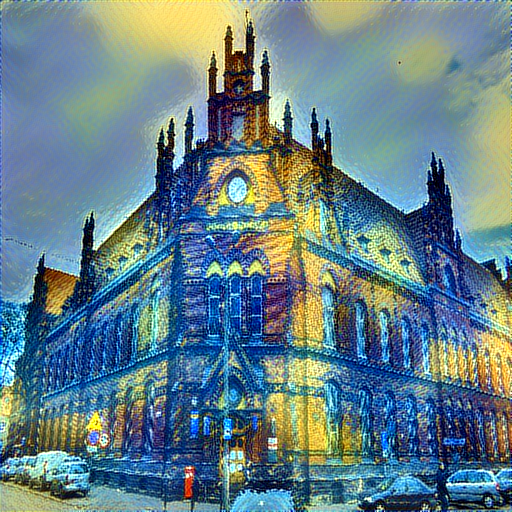

In [38]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

Modyfikując współczynniki:

* content_weight
* style_weight
* total_variation_weight

Możemy zmieniać wyjściowy obraz.

<img src="img/zestawienie.png">

Sprawdzałem jak sobie radzi z innymi obrazami, oto kilka przykładów:

<img src="img/rozne.png">

Wydaje mi się iż można osiągnąć lepsze rezultaty odpowiednio dobierając wzpółczynniki. Lecz wymaga to wielu prób.
***

Ograniczałem się do 10 epok, ilość epok również ma wpływ na jakość naszego obrazu, poniżej widzimy jak obraż się zmieniał co każdą epokę.
<img src="img/steps.gif">

***
# Podsumowanie


Model jest w stanie przekształcać obraz w dość interesujący sposób, wadą tego modelu jest czas który potrzebuje do stworzenia takowego obrazu. Ma moim laptopie obraz 512x512 pixeli potrzebował średnio 347s na każdą epokę co daje w sumie godzinę dla 10 epok. Udało mi się znaleźć publikacje która pozwala drastycznie skrócić czas wymagany do wygenerowania obrazu odstyłam do [publikacji](https://arxiv.org/abs/1603.08155) uznałem jednak iż implementacja tego zajmie zbyt wiele czasu który się kończył, dlatego postanowiłem dopracować aktualny model zamiast dodawać nowe elementy.

Uważam iż udało mi się zbliżyć do wyników które oferują aplikacje typu [Prisma](https://prisma-ai.com/) oraz strona [DeepArt](https://deepart.io/). Osobiście jestem zadowolony z wyników. Wiele czasu zajęło mi wykonanie tego projektu ale uważam to za cenne doświadczenie przy którym wiele się nauczyłem.
